In [1]:
!git clone https://github.com/afrenkai/DS-3010-Final.git

Cloning into 'DS-3010-Final'...
remote: Enumerating objects: 149, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 149 (delta 67), reused 81 (delta 24), pack-reused 0 (from 0)
Receiving objects: 100% (149/149), 18.29 MiB | 8.41 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [2]:
%cd DS-3010-Final

/content/DS-3010-Final


In [3]:
!ls
!pip install torcheval onnxruntime-gpu onnx

cv.py  LICENSE	   new_3010_proj_work_ben.ipynb  requirements.txt
Data   Main.ipynb  README.md
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.9 MB/s eta 0:00:00


In [14]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from lightgbm import LGBMRegressor
from torcheval.metrics import R2Score
import onnx
import matplotlib.pyplot as plt

In [5]:
train_df = pd.read_csv('Data/SGEMM_train.csv')
val_df = pd.read_csv('Data/SGEMM_val.csv')
test_df = pd.read_csv('Data/SGEMM_test.csv')
#TODO: read test data (already in data dir), see what's going on in lightgbm, get r2 for the neural net

# preprocessing

In [6]:
def norm(x, xmin, xmax, a, b):
  '''
  Restricts x values to range of [xmin, xmax]
  '''
  numerator = x - xmin
  denominator = xmax - xmin
  return (numerator / denominator) * (b - a) + a

In [7]:
cols_to_combine = ['Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)']

In [48]:
def preprocess(df: pd.DataFrame):
  df['DELTA_RUNTIME'] = df.apply(
      lambda row: np.mean([row['Run1 (ms)'], row['Run2 (ms)'], row['Run3 (ms)'], row['Run4 (ms)']]),
      axis=1
  )
  for col in df.columns:
    if col in cols_to_combine:
      df = df.drop(col, axis = 1) #removes redundant cols


  min = 0.1
  max = 1

  df = df.apply(
      lambda row: (norm(row, row.min(), row.max(), min, max))
  )
  x = df.iloc[:, :14] # features
  y = df.iloc[:, -1:] # target
  return x, y


In [49]:
x_tr, y_tr = preprocess(train_df)
x_val, y_val = preprocess(val_df)
x_test, y_test = preprocess(test_df)

In [50]:
y_tr.describe()

,DELTA_RUNTIME
count,193280.000000
mean,0.155218
std,0.099553
min,0.100000
25%,0.107400
50%,0.115287
75%,0.158021
max,1.000000


Text(0.5, 1.0, 'Distribution of DELTA_RUNTIME')

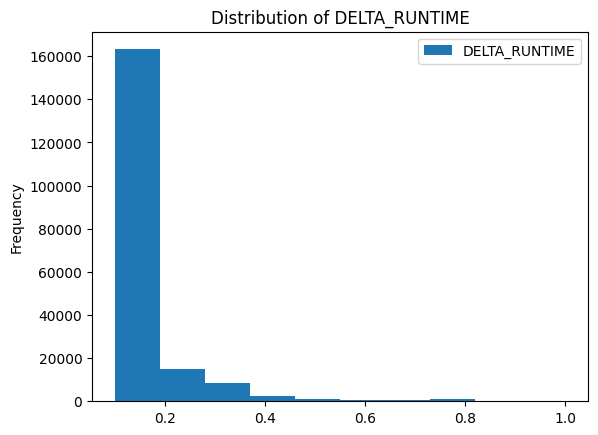

In [47]:
y_tr.plot.hist()
plt.title('Distribution of DELTA_RUNTIME')

# LightGBM

In [51]:

# train_data = lgb.Dataset(x_tr, label=y_tr)
# # Create a LightGBM dataset for testing with features X_val and labels Y_val,
# # and specify the reference dataset as train_data for consistent evaluation
# val_data = lgb.Dataset(x_val, label=y_val, reference=train_data)
# params = {
#     'objective': 'regression',
#     'metric': 'mse',
#     'boosting_type': 'gbdt',
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
# }

# num_round = 100
# bst = lgb.train(params, train_data, num_round, valid_sets=[
#                 val_data])A

model = LGBMRegressor(metric='mse')

model.fit(x_tr, y_tr)


y_train = model.predict(x_tr)
y_v = model.predict(x_val)
y_te = model.predict(x_test)

print("Training MSE:", mse(y_tr, y_train))
print("Validation MSE:", mse(y_val, y_v))
print("Test MSE", mse(y_test, y_te))
print('train r2:', r2_score(y_tr, y_train))
print('val r2:', r2_score(y_val, y_v))
print('test r2:', r2_score(y_test, y_te))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 54
[LightGBM] [Info] Number of data points in the train set: 193280, number of used features: 14
[LightGBM] [Info] Start training from score 0.155218
Training MSE: 9.759084307654406e-05
Validation MSE: 9.652084433390053e-05
Test MSE 0.00010295915977871622
train r2: 0.9901529624701716
val r2: 0.9903041141912599
test r2: 0.9900447385330113


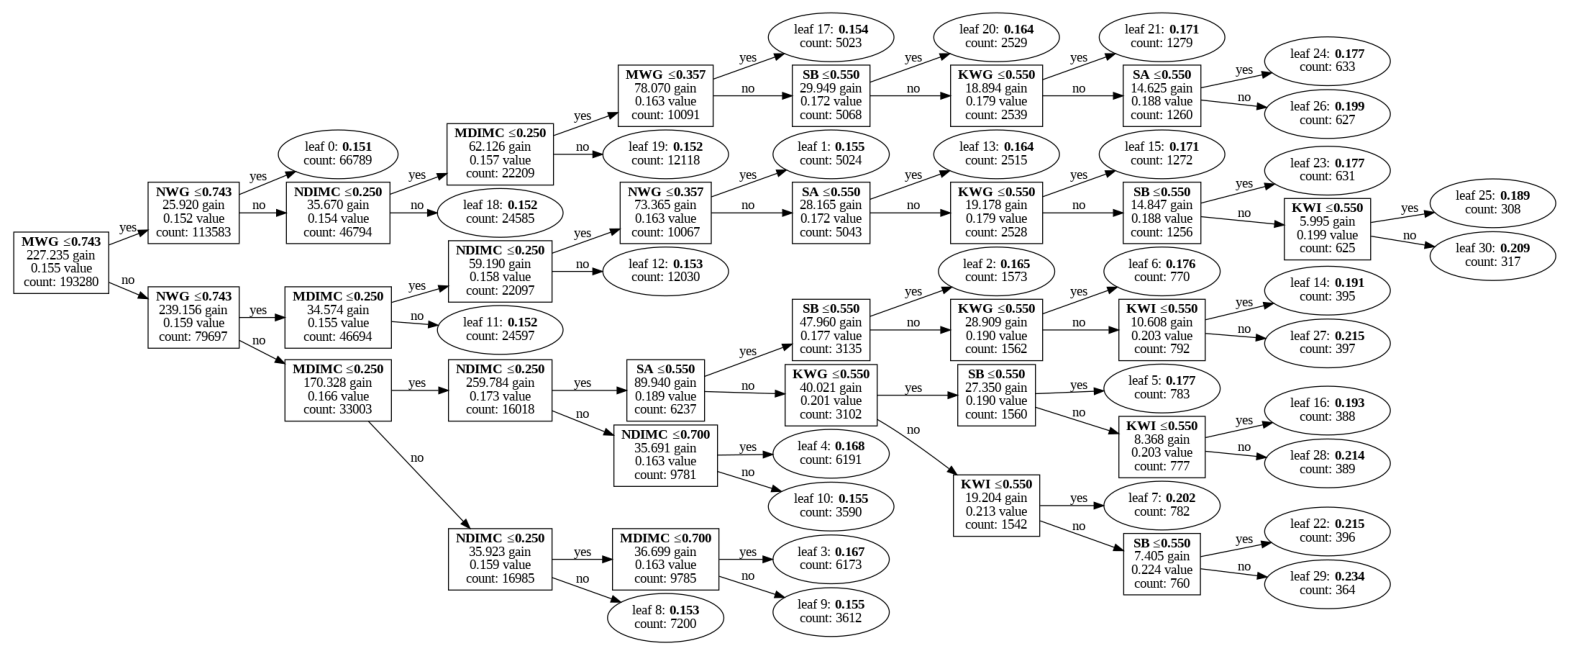

In [52]:
ax = lgb.plot_tree(model, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
plt.show()

# Simple Neural Net

In [53]:
class GPUNN(nn.Module):
  def __init__(self, in_feat, out_feat):
    super(GPUNN, self).__init__()
    self.device = 'cuda' if torch.cuda.is_available else 'cpu'
    self.L1 = nn.Linear(in_feat, 64, device=self.device)
    self.L2 = nn.Linear(64, out_feat, device = self.device)
    self.relu = nn.ReLU()
    self.bn1 = nn.BatchNorm1d(64, device = self.device)
    self.bn2 = nn.BatchNorm1d(out_feat, device = self.device)

  def forward(self, x):
    x = self.bn1(self.relu(self.L1(x)))
    x = self.bn2(self.L2(x))
    return x



In [54]:
# training output example was basen on an example from pytorch on using CNNs for ImageNet. https://github.com/pytorch/examples/blob/main/mnist/main.py
# lines 45-48 in original code, lines roughly 13-16 in ours
def train(model: nn.Module, train_dl: DataLoader, batch_size, device, n_epochs, optimizer, criterion):
    model.train()
    for epoch in trange(n_epochs):
        for batch, (data, target) in enumerate(train_dl):
            data, target = data.to(device).float(), target.to(device).float()
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            if batch % 193280 == 0:
                print('\nTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch + 1, batch * len(data), len(train_dl.dataset),
                    100. * batch / len(train_dl), loss.item()))

    torch.save(model.state_dict(), 'nn.pth')
    print('model saved to nn.pth')


In [55]:
#r2 score stuff taken from https://pytorch.org/torcheval/main/generated/torcheval.metrics.R2Score.html
#I think meaning loss over batches is fair, since that's a relatively good indicator of performance.
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    losses = []
    metric = R2Score()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device).float(), target.to(device).float()
            output = model(data)

            test_loss = criterion(output, target)
            # print('loss bien')
            # print(f'Target Tensor: {target.detach().cpu().numpy()}\n, Output Tensor:{output.detach().cpu().numpy()}\n')

            metric.update(output, target)
            # print(f' r2 rn: {metric.compute()}')

            # print('r2 bien')
            losses.append(test_loss)


    # print(test_loss / len(test_loader.dataset))
    # print(np.mean(r2s))
    r2 = metric.compute()
    r2 = float(r2.detach().cpu().numpy())
    # print(type(r2))
    # print(round(r2, 4))
    return (np.mean([ten.detach().cpu().numpy() for ten in losses]), round(r2, 4) )






In [86]:
def create_dls(x: pd.DataFrame, y:pd.DataFrame, split: str = 'train'):
  x = x.loc[:, :].values #conv to np array
  y = y.loc[:, :].values
  x_ten = torch.tensor(x) # conv to tensor
  y_ten = torch.tensor(y)
  ds = TensorDataset(x_ten, y_ten)
  if split == 'train':
    dl = DataLoader(ds, batch_size = 32, shuffle = True) #safe to shuffle since its train
  else:
    dl = DataLoader(ds, batch_size = 32, shuffle = False) #assuming test/val, can't shuffle
  return ds, dl

In [87]:
x_tr, y_tr = preprocess(train_df)
model = GPUNN(len(x_tr.columns), len(y_tr.columns))
print(model)
_, train_dl = create_dls(x_tr, y_tr, split = 'train')
criterion = nn.MSELoss() # MSE, like we've been using everywhere else
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3) # pretty standard, no need for k-fold since the method works pretty well without tuning
train(model, train_dl, 32, model.device, 10, optimizer, criterion) # 10 epochs to get a baseline.

GPUNN(
  (L1): Linear(in_features=14, out_features=64, bias=True)
  (L2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


  0%|          | 0/10 [00:00<?, ?it/s]


Train Epoch: 1 [0/193280 (0%)]	Loss: 1.059362


 10%|█         | 1/10 [00:12<01:48, 12.04s/it]


Train Epoch: 2 [0/193280 (0%)]	Loss: 0.005872


 20%|██        | 2/10 [00:24<01:36, 12.01s/it]


Train Epoch: 3 [0/193280 (0%)]	Loss: 0.006647


 30%|███       | 3/10 [00:36<01:24, 12.03s/it]


Train Epoch: 4 [0/193280 (0%)]	Loss: 0.005612


 40%|████      | 4/10 [00:48<01:12, 12.03s/it]


Train Epoch: 5 [0/193280 (0%)]	Loss: 0.003074


 50%|█████     | 5/10 [01:00<01:00, 12.04s/it]


Train Epoch: 6 [0/193280 (0%)]	Loss: 0.002775


 60%|██████    | 6/10 [01:12<00:48, 12.03s/it]


Train Epoch: 7 [0/193280 (0%)]	Loss: 0.001783


 70%|███████   | 7/10 [01:24<00:36, 12.03s/it]


Train Epoch: 8 [0/193280 (0%)]	Loss: 0.000675


 80%|████████  | 8/10 [01:36<00:24, 12.03s/it]


Train Epoch: 9 [0/193280 (0%)]	Loss: 0.000418


 90%|█████████ | 9/10 [01:48<00:12, 12.16s/it]


Train Epoch: 10 [0/193280 (0%)]	Loss: 0.005487


100%|██████████| 10/10 [02:00<00:00, 12.07s/it]

model saved to nn.pth


In [88]:
x_val, y_val = preprocess(val_df)
x_test, y_test = preprocess(test_df)
_, val_dl = create_dls(x_val, y_val, split = 'val')
_, test_dl = create_dls(x_test, y_test, split = 'test')
criterion = nn.MSELoss()
val_loss, val_r2= test(model, model.device, val_dl, criterion)
print(f'Neural Network Validation Mean Squared Error: {val_loss:.6f}')
print(f'Neural Network Validation R2: {val_r2}')

test_loss, test_r2 = test(model, model.device, test_dl, criterion)
print(f'Neural Network Test Mean Squared Error: {test_loss:.6f}')
print(f'Neural Network test R2: {test_r2}')

Neural Network Validation Mean Squared Error: 0.000463
Neural Network Validation R2: 0.9535
Neural Network Test Mean Squared Error: 0.000475
Neural Network test R2: 0.9541


In [89]:
dummy_input = torch.randn(1, 14).to(model.device)  # batch_size=1, in_feat=14

torch.onnx.export(model, dummy_input, "model.onnx",
                  input_names=["input"],
                  output_names=["output"],
                  opset_version=11)


In [63]:
# model.load_state_dict(torch.load('nn.pth', weights_only=True))
# print("Model's state_dict:")
# model.state_dict()

PCA, Lasso & Linear Regression - Katelyn

In [65]:
from sklearn.decomposition import PCA
x_tr, y_tr = preprocess(train_df)
x_val, y_val = preprocess(val_df)
x_test, y_test = preprocess(test_df)
pca = PCA(n_components=2)

X_train = pca.fit_transform(x_tr)
X_test = pca.transform(x_val)

explained_variance = pca.explained_variance_ratio_

print(explained_variance)


[0.10205183 0.10191195]


In [83]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
x_tr, y_tr = preprocess(train_df)
x_val, y_val = preprocess(val_df)
x_test, y_test = preprocess(test_df)
#From Sklearn --> Lasso documentation
x_tr = pca.fit_transform(x_tr)
x_val = pca.transform(x_val)
x_test = pca.transform(x_test)
#Setting alpha
lasso = Lasso(alpha=0.00001)

#Fitting to training data
lasso.fit(x_tr, y_tr)

#making y predictions based on the X_test, given by the PCA
y_val_pred = lasso.predict(x_val)
y_test_pred = lasso.predict(x_test)
#Getting the MSE
val_mse = mean_squared_error(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Validation Mean Squared Error: {val_mse}")
print(f"Test Mean Squared Error: {test_mse}")
print('validation r2:', r2_score(y_val, y_val_pred))
print('validation r2:', r2_score(y_test, y_test_pred))
print("Coefficients:", lasso.coef_)

#very low lasso coefficents
# literally no r2, deeper methods required

Validation Mean Squared Error: 0.009912129022392118
Test Mean Squared Error: 0.010296666199789199
validation r2: 0.004288951408835673
validation r2: 0.004401313321550027
Coefficients: [ 0.01247533 -0.00172306]


In [84]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

# Initialize Linreg and fit the model
linreg = LinearRegression()
linreg.fit(x_tr, y_tr)

# Predict on the test set
y_val_pred = linreg.predict(x_val)
y_test_pred = linreg.predict(x_test)

# Evaluate accuracy
val_mse = mean_squared_error(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Validation Mean Squared Error just linreg: {val_mse}")
print(f'Test Mean Squared Error with just linreg:  {test_mse}')
print('validation r2:', r2_score(y_val, y_val_pred))
print('validation r2:', r2_score(y_test, y_test_pred))

#see earlier comment about wonderful mse and bad r2

Validation Mean Squared Error just linreg: 0.009912093808809083
Test Mean Squared Error with just linreg:  0.010296678127646064
validation r2: 0.004292488747142165
validation r2: 0.004400160000815112
